# مقدمه
طول مدت روزه گرفتن در ماه رمضان، به خصوص برای عرض‌های بسیار شمالی و جنوبی گاها به ۲۴ ساعت می‌رسد. این نشان می‌دهد که معیار فعلی روزه گرفتن، که بر اساس اوقات شرعی (محلی) تنظیم شده، نمی‌تواند برای تمامی کره‌ زمین کاربردی باشد. 
برای مثال، من در ادامه نمودار میزان زمان روزه‌گرفتن در روزهای مختلف سال برای تمامی عرض‌های جغرافیایی شمالی را رسم می‌کنم ( عرض‌های جنوبی نموداری مشابه خواهند داشت با یک اختلاف شش ماهه).

برای محاسبه‌ی این نمودار از معیارهای تعیین اوقات شرعی (مطابق تعریف مرکز ژئوفیزیک دانشگاه تهران) استفاده شده است:

- **اذان صبح** وقتی است که خورشید ۱۷.۷ درجه زیر افق باشد
- **اذان مغرب** وقتی است که خورشید ۴.۵ درجه زیر افق باشد

هم‌چنین، مختصات خورشید در نیمه‌شب خورشیدی میانگین در مدار صفر درجه برای تمامی روزهای سال ۲۰۲۱ از نرم‌افزار  آزاد [استلاریوم](http://stellarium.org/) استخراج شده است. مقادیر معادله‌ی زمان برای سال ۲۰۲۱ نیز از [این جا](http://www.ppowers.com/EoT.htm) برداشته شده است.

In [1]:
import numpy as np
from numpy import sin, cos, tan, arcsin, arccos, arctan
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

from astropy.coordinates import Angle

In [2]:
# loading files: sun coordinates & Equation of time
def sun_date_parser(date_string):
    return (pd.to_datetime(date_string) + pd.Timedelta(seconds=1)).normalize()


def eot_date_parser(date_string):
    return (pd.to_datetime('2020 ' + date_string)).normalize()

sun = pd.read_csv('data/ephemeris.csv', usecols=['Date and Time', ' RA (J2000)', ' Dec (J2000)'],
                  parse_dates=['Date and Time'], date_parser=sun_date_parser,
                  index_col='Date and Time')

eot = pd.read_csv('data/EoT_2021.csv', usecols=['Date', 'EoT'],
                  parse_dates=['Date'], date_parser=eot_date_parser,
                  index_col='Date')

In [3]:
# Data cleaning

# renaming the columns and index and converting to degree
sun = sun.rename(mapper=dict(zip([' RA (J2000)', ' Dec (J2000)'], ['ra', 'dec'])),axis=1)
sun.ra = Angle(sun.ra).deg
sun.dec = Angle(sun.dec).deg

# only need to convert to timedelta object
eot = eot.EoT.iloc[:-1]
for idx in eot.index:
    m = round(float(eot[idx].split('m')[0]))  # minute
    s = round(float(eot[idx][:-1].split(' ')[1]))  # second
    eot[idx] = pd.Timedelta(days=0, minutes=m, seconds=s)

In [4]:
# Some global variables
r = np.pi / 180. # deg to rad
eps = 1e-8
dates = pd.date_range(start='2021-01-01', end='2021-12-31', freq='D')
cool_places = {'Equator':[0, 0], 'Mecca':[21.3891, 0],
               'Morning at Midnight':[48.85, 0],\
               'Night at Midnight':[62.05, 0],
               'Pole':[90,0],}

In [5]:
def color_phi(phi):
    """
    Just for coloring based on latitude
    """
    cmap = get_cmap('viridis', 90)
    r = abs(phi/90.)
    return cmap(r)


def get_sun(dates, landa):
    """
    Computes the sun coordinates at midnight of the given dates for
    location with longitude landa. The sun daily coordinates are 
    sampled at GMT midnight. The correct this on a non-zero longitude
    we linearly interpolate the sun coordinates between days using
    central finite difference.
    """
    
    idx = np.where([sun.index == date for date in dates])[1]  # index of the date
    idxn = (idx - 1) % len(sun) 
    idxp = (idx + 1) % len(sun) 
    
    ra, dec = sun.ra.iloc[idx].values, sun.dec.iloc[idx].values # at GMT
    ran, decn = sun.ra.iloc[idxn].values, sun.dec.iloc[idxn].values # at GMT
    rap, decp = sun.ra.iloc[idxp].values, sun.dec.iloc[idxp].values # at GMT

    # interpolate
    dec = dec - (decp - decn)/720. * (landa - 180)
    ra = ra - (rap - ran)/720. * (landa - 180)
    
    return ra, dec


def compute_day_time(coords, dates, a_set=-4.5, a_rise=-17.7):
    """
    compute the day_time, given the altitutes of rising and setting.
    
    Assumptions:
        1. The sun is fixed during one solar day
        2. The sun coordinates changes linearly from the one midnight (of UTC) to the other
        3. When the rise/set altitude requirements are not met, the hour angle is set to +/-12h.
    
    a_set:    the altitude of center of the sun at maqrib azaan
    a_rize:   the altitude of center of the sun at morning azaan
    dates:    the dates overwhich the fasting duration is desired (list of Timestaps)
    coords:   location coordinates in degree
    """
    phi, landa = coords
    ra, dec = get_sun(dates, landa)
    
    cos_Hrise = (sin(r * a_rise) -
                 sin(r * phi) * sin(r * dec)) / (cos(r * phi) * cos(r * dec))
    cos_Hset = (sin(r * a_set) - sin(r * phi) * sin(r * dec)) / (cos(r * phi) *
                                                                 cos(r * dec))

    # cap the cos values
    cos_Hset = np.clip(cos_Hset, -1. + eps, 1. - eps)
    cos_Hrise = np.clip(cos_Hrise, -1. + eps, 1. - eps)

    Hrise = arccos(cos_Hrise)
    Hset = arccos(cos_Hset)

    return (Hset + Hrise) / (r * 15.)

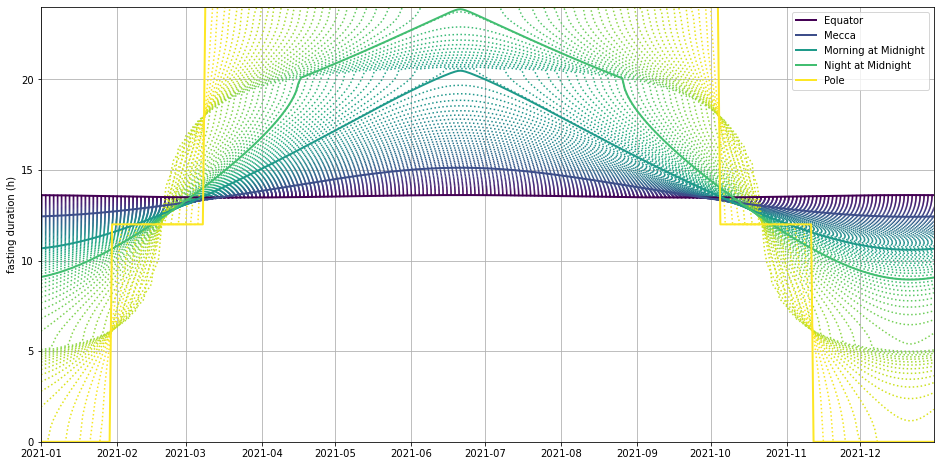

In [6]:
# visualizing model 0
fig = plt.figure(figsize=(16, 8))
ax = plt.gca()

arr = np.zeros((90,len(dates)))
for phi in range(0,90):
    coords = float(phi), 0.0
    t = compute_day_time(coords, dates)
    arr[phi,:] = t
    ax.plot(dates, t, color = color_phi(phi) , alpha=1-0.5*(phi<0), linestyle= ':')

for place in cool_places.keys():
    coord_ = cool_places[place]
    t_ = compute_day_time(coord_, dates)   # equator
    ax.plot(dates, t_, color=color_phi(coord_[0]), label=place, linewidth=2)
            
ax.legend()
ax.grid()
ax.set_ylabel('fasting duration (h)')
ax.set_ylim(0,24);
ax.set_xlim(dates[0], dates[-1]);

این نمودار چند رفتار مشخصه دارد:

- طول زمان روزه گرفتن در استوا تقریبا ثابت (و برابر با ۱۳.۵ ساعت) است
- هر چه عرض افزایش می‌یابد، تغییرات زمان روزه گرفتن بیشتر می‌شود. به طور مثال ساکنین شهر مکه، روزه‌هایی به طول ۱۲ تا ۱۵ ساعت را تجربه می‌کنند. اما ساکنین شهر مشهد، از ۱۱ ساعت تا نزدیک یه ۱۷ ساعت روزه می‌گیرند.
- در عرض‌های شمالی‌تر، اذان صبح بسیار زود و اذان مغرب بسیار دیر گفته خواهد شد. به طوری که از عرض ۴۹ درجه شمالی به بعد، در روزهای خاصی از سال، نیمه‌شب شرعی و اذان صبح بر هم منطبق می‌شوند. بالاتر از عرض ۶۲ درجه، در این روزهای خاص، حتی اذان مغرب هم در نیمه‌شب رخ می‌دهد؛ و این به معنای آنست که طول روزه گرفتن با طول شبانه روز برابر می‌شود.
- در (حالت حدی) قطب شمال، از کمی قبل از آغاز بهار تا کمی بعد از پایان تابستان، در تمامی طول روز باید روزه گرفته شود. در تمامی زمستان طول زمان روزه صفر است. و در زمان گذار بین پاییز به زمستان و زمستان به بهار، مجموعا نزدیک یه ۲.۵ ماه، ۱۲ ساعت باید روزه گرفته شود. 

به طور معادل، می‌توان به احتمال وجود روزه‌ی بلندمدت (مثلا بیش از ۱۷ ساعت) در طول سال برای هر عرض جغرافیایی نگاه کرد. البته باید توجه کرد که به دلیل انحنای زمین، یک بازه‌ی یک درجه‌ای عرض، در عرض‌های جغرافیایی بالا، مساحت کوچکتری از کره‌ی زمین را در مقایسه با همان نوار یک درجه‌ای در عرض‌های استوایی‌تر می‌پوشاند. نمودار زیر،این احتمال را با تصحیح اثر انحنای زمین نشان می‌دهد.

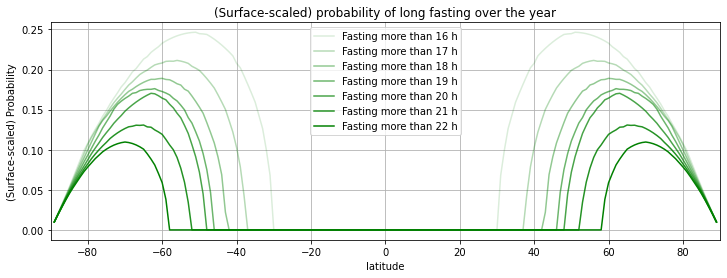

In [7]:
surf = [cos(i*r) for i in range(0,90)]

plt.figure(figsize=(12,4))
for long in [16, 17, 18, 19, 20, 21, 22]:
    prob = np.where(arr>=long, True, False).sum(axis=1)/arr.shape[1]*surf
    plt.plot(range(-89,90),(np.concatenate((prob[:0:-1],prob))),\
             label = 'Fasting more than {} h'.format(long),\
             color = 'g', alpha=(long-15)/7.)
plt.title('(Surface-scaled) probability of long fasting over the year')

plt.xlabel('latitude')
plt.ylabel('(Surface-scaled) Probability')
plt.legend(loc='best')
plt.xlim(-90,90)
plt.grid()

پیام نمودار بالا آن است که از عر جغرافیایی ۴۰ به بعد، روزه‌های طولانی مستمرا بیشتر می‌شوند. با توجه به این واقعیت، به نظرم می‌توان به راهکاری برای *تصحیح* معیار اذان در عرض‌های بالا رسید که در ادامه توضیحش می‌دهم. 

# یک ایده‌ی ساده
ساده، این ارتفاع خورشید است که زمان اذان را مشخص می‌کند. اما موقعیت خورشید در هر لحظه، به مکان وابسته است و همین وابستگی است که چنین تغییراتی را سبب می‌شوند. البته این معیار بسیار طبیعی است. شب و روز بودن، بدون شک، تنها با موقعیت خورشید است که تعیین می‌شوند. اما ارتفاع خورشید در آسمان، تنها سنجه از گذر زمان از شب به روز  نیست. مثلا می‌توان (کاملا قرارداری) نیمی از ۲۴ ساعت شبانه‌روز را شب و نیمی دیگر را روز نامید. البته طبیعی است که  تمامی نقاط زمین، هم‌زمان روز یا شب نخواهند بود. با این حال طول شب یا روز یکسانی خواهند داشت. این که روز (یا شب) کی آغاز شود، صرفا به طول جغرافیایی محل مربوط خواهد بود، به طور ساده به این که شهر در قسمت شرقی زمین است یا قسمت غربی آن. اما این زمان آغاز، طول روز و شب را عوض نخواهد کرد. یک انتخاب طبیعی آن است که 
شروع نیمه‌ی روز طوری باشد که ظهر (بلندترین موقعیت خورشید در یک روز) دقیقا در وسط این آن اتفاق بیافتد.

نکته‌ی جالب این که همین ایده‌ی ساده، سبب می‌شود که در محل‌هایی، روز قبل از طلوع خورشید (رسما) آغاز شود یا شب بسیار پس از غروب خورشید. یا برعکس، می‌توان با وجود خورشید در آسمان شب داشت، و روزی بدون خورشید. اما تمامی این حالات را می‌توان با یک تصویر ذهنی ساده از کره‌ی زمین ِگردان در فضا توضیح داد: شب و روز نه با خورشید، بلکه با توجه به این که زمین چند درجه حول محورش چرخیده تعریف می‌شود.


اهل فن به این زاویه‌ی چرخش زمین را زاویه ساعتی می‌گویند. در اصل کافی است که ما برای زاویه‌ی ساعتی آغاز شب و روز را تعریف کنیم. مثلا بگوییم که دوست داریم روز، ساعت ۶ بامداد و شب ۱۸ شروع شوند. با این وصف، طول روز در همه‌جا ۱۲=۶-۱۸ خواهد بود. به همین سادگی!

اما بگذارید ببینیم که با این تعریف، در حین آغاز و پایان روز، ارتفاع خورشید در جاهای مختلف چقدر است.

In [8]:
def compute_alt_from_ha(coords, dates, h1=-6*15, h2=+6*15):
    """
    compute the altitudes given hour angles of rising and setting
    
    Assumptions:
        1. The sun is fixed during one solar day
        2. The sun coordinates changes linearly from the one midnight (of UTC) to the other
        3. When the rise/set altitude requirements are not met, the hour angle is set to +/-12h.
    
    a_set:    the altitude of center of the sun at maqrib azaan
    a_rize:   the altitude of center of the sun at morning azaan
    dates:    the dates overwhich the fasting duration is desired (list of Timestaps)
    coords:   location coordinates in degree
    """
    phi, landa = coords
    ra, dec = get_sun (dates, landa)
    
    sin_a1 = sin(r* phi)*sin(r* dec)+cos(r* phi)*cos(r* dec)*cos(r*h1)
    sin_a2 = sin(r* phi)*sin(r* dec)+cos(r* phi)*cos(r* dec)*cos(r*h2)
    
    # cap the cos values
    sin_a1 = np.clip(sin_a1, -1. + eps, 1. - eps)
    sin_a2 = np.clip(sin_a2, -1. + eps, 1. - eps)
    
    a1 = arcsin(sin_a1)
    a2 = arcsin(sin_a2)
    return a1/r , a2/r

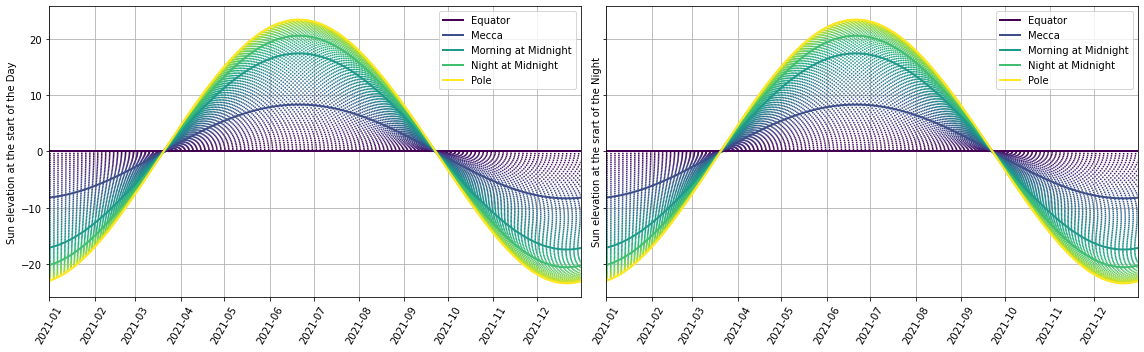

In [9]:
fig, axs = plt.subplots(1,2, figsize=(16, 5), sharey=True)

phis = range(0,90)
for phi in phis:
    coord_ = float(phi), 0.0
    a1,a2 = compute_alt_from_ha(coord_, dates)
    axs[0].plot(dates, a1, color = color_phi(phi), linestyle= ':')
    axs[1].plot(dates, a2, color = color_phi(phi), linestyle= ':')


for place in cool_places.keys():
    coord_ = cool_places[place]
    a1,a2 = compute_alt_from_ha(coord_, dates)
    axs[0].plot(dates, a1, color = color_phi(coord_[0]),label=place, linewidth=2)
    axs[1].plot(dates, a2, color = color_phi(coord_[0]),label=place, linewidth=2)

for ax in axs:
    ax.hlines(0,ax.get_xlim()[0],ax.get_xlim()[1],color='k', linestyle='--')
    ax.legend()
    ax.grid()
    ax.set_xlim(dates[0], dates[-1])
    ax.tick_params(axis='x',rotation=60)

axs[0].set_ylabel('Sun elevation at the start of the Day')
axs[1].set_ylabel('Sun elevation at the srart of the Night')
plt.tight_layout()

این دو نمودار نشان می‌دهد که در بهار و تابستان، (در عرض‌های شمالی) شب، با وجود خورشید در آسمان آغاز شده و تمام می‌شود. به طور مشابه، در زمستان و پاییز، روز وقتی شروع (و تمام) می‌شود که خورشید هنوز طلوع (و غروب) نکرده است. تنها استثنا استواست که همواره طلوع و غروب با آغاز روز و شب همزمانند.


# ادغام
معیار بالا چندان معیار جالبی نیست. چون بر خلاف معیار سابق که تنها عرض‌های شمالی را درگیر می‌کرد، این تمامی عرض‌ها را مناثر می‌کند و این در حالی است که عرض‌های استوایی، اساسا مشکلی با معیار عرفی فعلی ندارند!

یک راه حل مناسب ادغام این دو روش است به نحوی که در عرض‌های پایین (مثلا تا ۵۰ درجه) شب و روز مطابق معیار طبیعیشان (طلوع و غروب) تعیین شوند و به مرور، با رفتن به عرض‌های قطبی‌تر معیار دوم پر رنگ‌تر شود. 

من این ادغام را با میانگین‌گیری وزن‌دار روی زاویه‌ساعتی خورشید بر اساس دو معیار انجام می‌دهم. به طور دقیق‌تر با تعریف یک تابع وزن$w$ (که به عرض جغرافیایی) مرتبط است، زاویه‌ی ساعتی مدل ادغامی را محاسبه می‌کنم:

$$H = w(\phi) H_1 + [1-w(\phi)] H_2$$

توجه کنید که هر دو معیار فعلی اوقات شرعی (۱) و معیار اخیر (۲)، که بر پایه‌ی زاویه‌ی چرخش زمین تعریف شد، دو پارامتر آزاد دارند. پارامترهای آزاد معیار اوقات شرعی، ارتفاع‌های خورشید در لحظه‌ی اذان صبح و مغرب هستند. اما پارامترهای معیار دیگر زاویه‌های ساعتی خورشید (میزان زاویه‌ی چرخش زمین نسبت به ظهر) در آغاز و پایان روز. هر چند که من به پارامترهای معیار ۱ دست نخواهم برد، اما توجه به این نکته ضروری است که ما این اعداد را از مرکز ژئوفیزیک دانشگاه تهران استخراج کرده‌ایم و اصولا می‌توان با روش‌های دیگری هم لحظه‌ی اذان را تعریف کرد. مثلا نگاه کنید به [این]().

از سوی مقابل، پارمترهای آزاد معیار ۲ تماما در اختیار ما هستند. در قبل ساعات ۶ و ۱۸ به عنوان زمان شروع و پایان روز انتخاب شد. اما می‌توان انتخاب‌های بهتری داشت که با مذهب سازگارتر هم باشند. مثلا پیشنهاد من، انتخاب حد بالا و پایین زاویه ساعتی در شهر مکه در زمان اذان صبح و مغرب است:

$$\cos H_{rise} = [\sin (a_{rise}) - \sin \phi \sin \epsilon] / (\cos \phi \cos \epsilon)$$
$$\cos H_{set} = [\sin (a_{set}) - \sin \phi \sin \epsilon] / (\cos \phi \cos \epsilon)$$

$$H_{rise} = -8.11425\  hour \hspace{1cm} H_{set} = 7.01112\ hour$$

این اعداد، نمودار ارتفاع خورشید در آغاز و پایان روز را بدین شکل تغییر خواهد داد؛ که نشان می‌دهد از استوا تا عرض نزدیک به ۵۵ درجه، اذان صبح (یا شروع روز) همواره قبل از طلوع خورشید خواهد بود. اما در عرض‌های شمالی‌تر، در برخی زمان‌ها در سال، روز پس از طلوع خورشید آغاز می‌شود. از سمت مقابل، اذان مغرب (پایان روز) برای عرض‌های بیش از ۳۰ درجه، در برخی روز‌ها در زمان بالای افق بودن خورشید رخ می‌دهد.

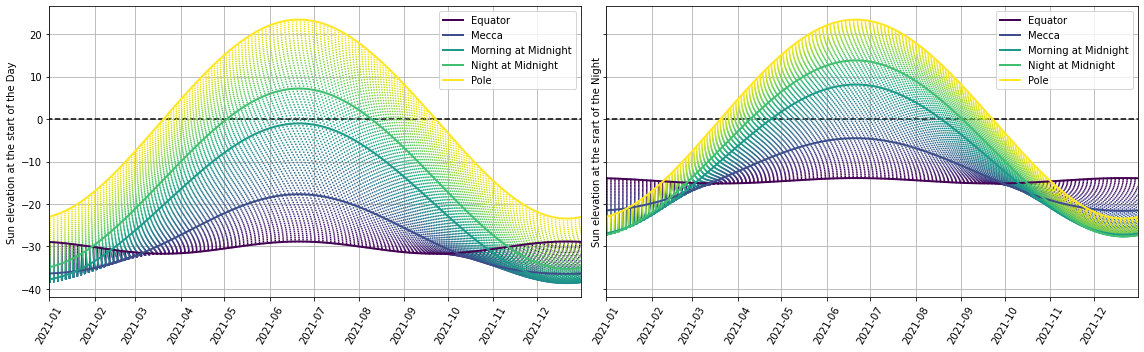

In [10]:
h1,h2=-8.11425*15.,+7.01112*15.
fig, axs = plt.subplots(1,2, figsize=(16, 5), sharey=True)

for phi in range(0,90):
    coord_ = float(phi), 0.0
    a1,a2 = compute_alt_from_ha(coord_, dates, h1, h2)
    axs[0].plot(dates, a1, color = color_phi(phi), linestyle= ':')
    axs[1].plot(dates, a2, color = color_phi(phi), linestyle= ':')


for place in cool_places.keys():
    coord_ = cool_places[place]
    a1,a2 = compute_alt_from_ha(coord_, dates, h1, h2)
    axs[0].plot(dates, a1, color = color_phi(coord_[0]),label=place, linewidth=2)
    axs[1].plot(dates, a2, color = color_phi(coord_[0]),label=place, linewidth=2)

for ax in axs:
    ax.hlines(0,ax.get_xlim()[0],ax.get_xlim()[1],color='k', linestyle='--')
    ax.legend()
    ax.grid()
    ax.set_xlim(dates[0], dates[-1])
    ax.tick_params(axis='x',rotation=60)

axs[0].set_ylabel('Sun elevation at the start of the Day')
axs[1].set_ylabel('Sun elevation at the srart of the Night')
plt.tight_layout()

برای تابع وزن، ما به دنبال تابعی هستیم که به نرمی و یکنوا از مقدار ۱ در استوا به مقدار ۰ در قطب تغییر کند. من به دلخواه (و برای سادگی) تابعی خطی را انتخاب کرده‌ام با ذکر این نکته که بی‌نهایت تابع دیگر می‌توان انتخاب کرد.

$$w(\phi) = 1-\frac{|\phi|}{90}$$

In [11]:
def blend_models(coords, dates, no_blend=False,
                 a_set=-4.5, a_rise=-17.7, h_rise=-8.11425*15, h_set=+7.01112*15):
    """
    compute the day_time.
    
    Assumptions:
        1. The sun is fixed during one solar day
        2. The sun coordinates changes linearly from the one midnight (of UTC) to the other
        3. When the rise/set altitude requirements are not met, the hour angle is set to +/-12h.
    
    a_set:    the altitude of center of the sun at maqrib azaan
    a_rize:   the altitude of center of the sun at morning azaan
    dates:    the dates overwhich the fasting duration is desired (list of Timestaps)
    coords:   location coordinates in degree
    no_blend: turns off blending and yield the default model
    
    outputs:
    
    t:             duration of fasting (h)
    a_set_blend:   blended altitude of sun at set (degree)
    a_rise_blend:  blended altitude of sun at rise (degree)
    H_set_blend:   blended hour angle of setting (h)
    H_rise_blend:  blended hour angle of rising (h)
    """
    phi, landa = coords
    ra, dec = get_sun (dates, landa)
    
    # let's compute the default model (model 0) h and a in set and rise
    cos_h_rise_0 = (sin(r * a_rise) -
                 sin(r * phi) * sin(r * dec)) / (cos(r * phi) * cos(r * dec))
    cos_h_set_0 = (sin(r * a_set) - sin(r * phi) * sin(r * dec)) / (cos(r * phi) *
                                                                 cos(r * dec))
    # cap the cos values
    cos_h_set_0 = np.clip(cos_h_set_0, -1. + eps, 1. - eps)
    cos_h_rise_0 = np.clip(cos_h_rise_0, -1. + eps, 1. - eps)

    h_rise_0 = -arccos(cos_h_rise_0)/r
    h_set_0 = arccos(cos_h_set_0)/r

    # blend_factor
    if no_blend:
        w = 1
    else:
        w = (1-abs(phi/90.)) # cos(r* abs(phi))

    H_rise_blend = h_rise_0 * w + h_rise * (1-w)
    H_set_blend = h_set_0 * w + h_set * (1-w)
    
    # compute a at blendded h
    sin_a_set_blend = sin(r* phi)*sin(r* dec)+cos(r* phi)*cos(r* dec)*cos(r*H_set_blend)
    sin_a_rise_blend = sin(r* phi)*sin(r* dec)+cos(r* phi)*cos(r* dec)*cos(r*H_rise_blend)
    
    # cap the cos values
    sin_a_set_blend = np.clip(sin_a_set_blend, -1. + eps, 1. - eps)
    sin_a_rise_blend = np.clip(sin_a_rise_blend, -1. + eps, 1. - eps)
    
    a_set_blend = arcsin(sin_a_set_blend)/r
    a_rise_blend = arcsin(sin_a_rise_blend)/r
    t = (H_set_blend - H_rise_blend)/(15.)
    
    return t, a_set_blend, a_rise_blend, H_set_blend, H_rise_blend

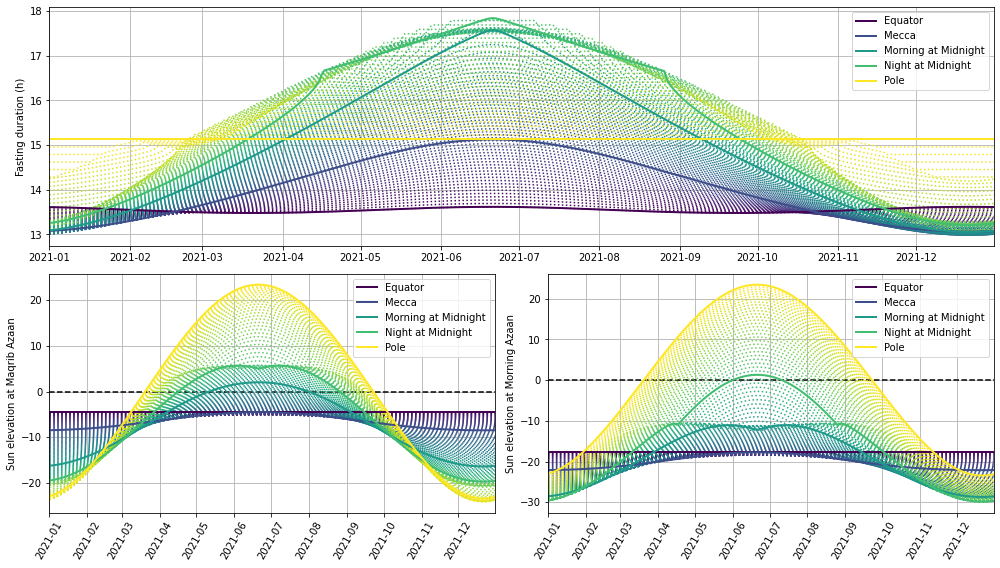

In [12]:
fig,axs = plt.subplot_mosaic(
    """
    AA
    BC
    """,figsize=(14, 8)) 

phis = range(0,90)
arr_ = np.zeros((len(phis),len(dates)))
for phi in phis:
    coord_ = float(phi), 0.0
    t_, a1_, a2_, _, _ = blend_models(coord_, dates)
    arr_[phi,:]=t_
    axs['A'].plot(dates, t_, color = color_phi(phi) , linestyle= ':')
    axs['B'].plot(dates, a1_, color = color_phi(phi), linestyle= ':') # set
    axs['C'].plot(dates, a2_, color = color_phi(phi), linestyle= ':') # rise


for place in cool_places.keys():
    coord_ = cool_places[place]
    t_, a1_ ,a2_, _, _ = blend_models(coord_, dates)
    axs['A'].plot(dates, t_, color = color_phi(coord_[0]),label=place, linewidth=2,)
    axs['B'].plot(dates, a1_, color = color_phi(coord_[0]),label=place, linewidth=2)
    axs['C'].plot(dates, a2_, color = color_phi(coord_[0]),label=place, linewidth=2)

for id_ in axs:
    ax = axs[id_]
    ax.legend()
    ax.grid()
    ax.set_xlim(dates[0], dates[-1])
    if id_!='A': 
        ax.hlines(0,ax.get_xlim()[0],ax.get_xlim()[1],color='k', linestyle='--')
        ax.tick_params(axis='x',rotation=60)
        
axs['A'].set_ylabel('Fasting duration (h)')
axs['B'].set_ylabel('Sun elevation at Maqrib Azaan')
axs['C'].set_ylabel('Sun elevation at Morning Azaan');
plt.tight_layout()

ادغام دو معیار به سه نمودار بالا منتج می‌شود. نمودار اول نشان می‌دهد که زمان روزه برای تمامی عرض‌ها در تمامی طول سال بین ۱۳ تا کمی کمتر از ۱۸ساعت تغییر خواهد کرد. به علاوه بیشترین زمان روزه مربوط به عرض‌های میانی است و به طور ویژه، در قطب طول مدت روزه همواره کمی بیش از ۱۵ ساعت خواهد بود.

نمودارهای دوم و سوم هم نشان می‌دهند که مشابه با عرف فعلی، زمان اذان مغرب در بیشتر عرض‌های جغرافیایی استوایی  همواره پس از غروب خورشید خواهد بود. زمان اذان صبح امااز عرض حدودا ۴۵ درجه به بعد، گاهی اوقات پس از طلوع خورشید است. 

# اثر رویکرد پیشنهادی
طول زمان روزه گرفتن و تغییرات آن برای هر عرض و در طول سال در نمودارهای زیر رسم شده است. با وجود این که عرض‌های  میانی (همان‌هایی که بیشتری مشکل را با روزه‌های بلندمدت دارند) بیشترین زمان روزه‌داری را مطابق این رویکرد دارند، همزمان، بیشترین کاهش درطول زمان روزداری را هم تجربه می‌کنند، به طوری که حتی در طولانی‌ترین روزه‌ها، کمی‌ کمتر از ۱۸ ساعت روزه باید گرفته شود.

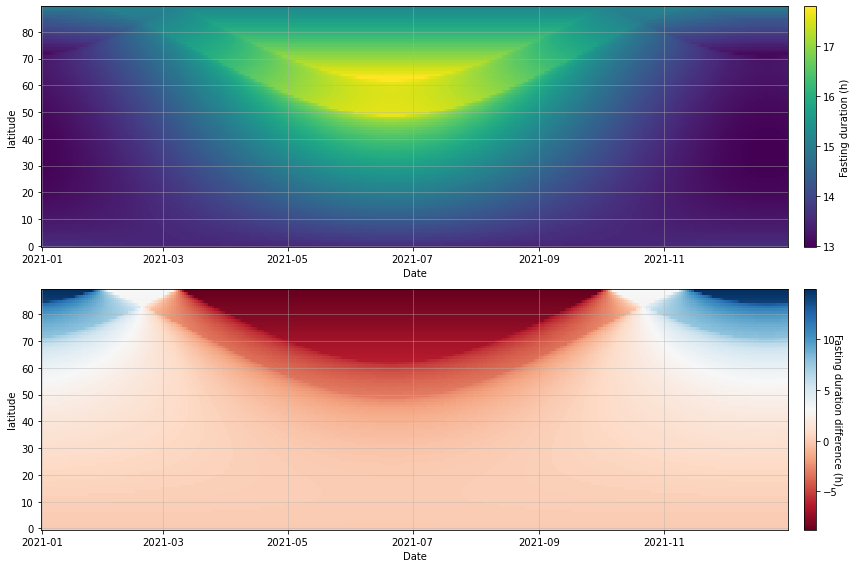

In [13]:
fig,axs = plt.subplots(2,1,figsize=(12,8),)

ax = plt.sca(axs[0])
c = plt.pcolor(dates, range(0,90), arr_, cmap='viridis',shading='auto')
cb = fig.colorbar(c, ax=ax, pad=0.02, fraction=0.02)
cb.set_label("Fasting duration (h)", rotation=90)

ax = plt.sca(axs[1])
c = plt.pcolor(dates, range(0,90), arr_-arr, cmap='RdBu',shading='auto')
cb= fig.colorbar(c, ax=ax, pad=0.02, fraction=0.02)
cb.set_label("Fasting duration difference (h)", rotation=270)

# ax.subtitle('Fasting duration difference (h)')

for ax in axs:
    ax.set_ylabel('latitude')
    ax.set_xlabel('Date')
    ax.grid(alpha=0.5)

plt.tight_layout()



نمودار زیر نشان می‌دهد که احتمال روزه‌های بلند، تماما حذف شده است و این رویکرد ادغامی، علی‌رقم سادگی‌اش، کاراست.

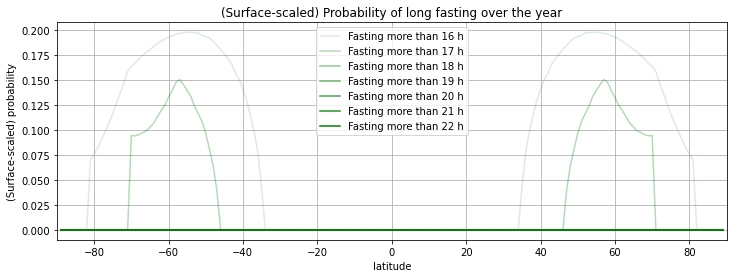

In [14]:
surf = [cos(i*r) for i in range(0,90)]

plt.figure(figsize=(12,4))
for long in [16, 17, 18, 19, 20, 21, 22]:
    prob = np.where(arr_>=long, True, False).sum(axis=1)/arr_.shape[1]*surf
    plt.plot(range(-89,90),(np.concatenate((prob[:0:-1],prob))),\
             label = 'Fasting more than {} h'.format(long),\
             color = 'g', alpha=(long-15)/7.)
plt.title('(Surface-scaled) Probability of long fasting over the year')

plt.xlabel('latitude')
plt.ylabel('(Surface-scaled) probability')
plt.legend(loc='best')
plt.xlim(-90,90)
plt.grid()

#  میانگین ساعات روزه گرفتن برای کشورها

In [15]:
from timezonefinder import TimezoneFinder
import time

def find_local_noon(coords, dates, eot, split_from_noon=True, no_blend=False):
    """
    finds the civil time of local noon, morning and
    maqrib for all the days in the year. Day time saving
    are taken into account. However, as the sun coordinates
    are sampled, an extention of 1-minute from both sides
    (morning and maqrib) is recommended, when used in 
    practice.
    
    two dataframes will be produced with the same content 
    but different format. the first one, shows the morning,
    noon, and maqrib times, as well as duration in HH:MM:SS
    format as string. The second one yields the same in 
    float (in hours).
    
    Equations:
    ==========
    
    EoT = HA - HAMS
    LMT = 12 + HAMS
    CT = LMT - longitude + timezone
    
    Notes:
    ======
    - longitude > 0 for eastern locations
    - timezone > 0 for eastern locations
    
    Example for noon (HA = 0)
    ======
    CT_noon = -EoT + 12 - longitude + timezone
    CT_morn = CT_noon - duration/2
    CT_maqr = CT_noon + duration/2
    """
    t, aset, arise, hset, hrise = blend_models(coords, dates, no_blend=no_blend)
    
    # timezone name
    tzn = TimezoneFinder().timezone_at(lng=coords[1], lat=coords[0]) 
    
    # offsets
    ## equation of time
    offset_eot = np.array([e.total_seconds()/3600. for e in eot.values])
    ## longitude
    offset_lng = np.ones_like(offset_eot)*coords[1]/15
    ## timezone
    offset_tz = [date.utcoffset().total_seconds()/3600 for date in\
                 dates.tz_localize(tzn, nonexistent='shift_backward')]
    # TODO: On dates on which DST is activated or deactivated ambiguity
    #       in time will occur. Depending on the season, shift in 
    #       forward or backward is needed!!!
    
    
    t_noon = - offset_eot - offset_lng + offset_tz + 12
    
    if split_from_noon:
        t_start = t_noon - t/2
        t_end = t_noon + t/2
    else:
        t_start = t_noon + hrise/15.
        t_end = t_noon + hset/15.
        
    df_num = pd.DataFrame(index = dates, 
                          data={'start':t_start,'noon':t_noon, 'end':t_end,'duration':t},
                          dtype=float)
    
    t_start = [time.strftime("%H:%M:%S", time.gmtime(start*3600)) for start in t_start]
    t_noon = [time.strftime("%H:%M:%S", time.gmtime(noon*3600)) for noon in t_noon]
    t_end = [time.strftime("%H:%M:%S", time.gmtime(end*3600)) for end in t_end]
    durs = [time.strftime("%H:%M:%S", time.gmtime(dur*3600)) for dur in t]
    
    df = pd.DataFrame(index = dates,
                      data={'start':t_start,'noon':t_noon, 'end':t_end,'duration':durs},
                      dtype=str)
    
    return df,df_num

def mean_fasting_duration(eot, start_date, month_length=30, coords=None, no_blend=False):
    """
    given a starting date and a length for the month, the average
    of fasting duration is computated (optionally for a set of 
    coordiantes, otherwise on all latitudes).
    """
    if coords==None:
        phis = np.arange(-90,91,1)
        landas = np.zeros_like(phis)
        coords = zip(phis, landas)
        
    idx_start = np.where(dates==start_date)[0][0]
    idx_end = idx_start + month_length +1
    dates_ = dates[idx_start:idx_end]
    eot_ = eot[idx_start:idx_end]
    
    durations = []
    for (phi, landa) in coords:
        _,df_num = find_local_noon((phi,landa), dates=dates_, eot=eot_, no_blend=no_blend)
        durations.append(df_num.duration.mean())
        
    return durations

In [16]:
import json
import folium
# obtaining countries coordiantes from open access dats
# https://github.com/mledoze/countries/dist/countries.csv

# only latlng is needed for computations. Others are just for either
# vis or later justification.
df = pd.read_csv('data/countries.csv', usecols=['cioc','cca2','cca3','latlng',
                                           'area', 'independent','flag'])

coords = [(float(x.split(',')[0]), float(x.split(',')[1])) for x in df.latlng]


# computing mean duration for all countries
ramazan_start = '2021-04-13' # this year..
dur_blend= mean_fasting_duration(eot, ramazan_start, month_length=30, coords=coords)
dur_noblend= mean_fasting_duration(eot, ramazan_start, month_length=30, coords=coords, no_blend=True)
df['duration_b'] = dur_blend
df['duration'] = dur_noblend

In [19]:
# some open access geofiles: either load from url or from hard disk
# geo_data = 'https://datahub.io/core/geo-countries/r/0.geojson'
geo_data = 'data/countries.geojson'

geo= open(geo_data,'r')
txt = geo.read()
data =json.loads(txt)
del txt
geo.close()

In [20]:
def style_by_duration(feature):
    i = feature['properties']['ISO_A3']
    try:
        dur = df.set_index('cca3').loc[i,'duration']
    except KeyError:
        dur = None
        
    return {
        "fillOpacity": 0.8,
        "weight": 0,
        'line_opacity':0.5,
        "fillColor": "#black" if dur is None else colorscale(dur),
        "legend_name":"Fasting duration (h)",
        "caption":"Default model",
    }

def style_by_duration_b(feature):
    i = feature['properties']['ISO_A3']
    try:
        dur = df.set_index('cca3').loc[i,'duration_b']
    except KeyError:
        dur = None
        
    return {
        "fillOpacity": 0.8,
        "weight": 0,
        'line_opacity':0.5,
        "fillColor": "#black" if dur is None else colorscale(dur),
        "legend_name":"Fasting duration (h)",
        "caption":"Blended model",
        }

def highlight_function(x):
            return {'weight': 2,
                    'color':'black'}

In [22]:
import branca
colorscale = branca.colormap.LinearColormap(['#479815', '#2D6CD2', '#E41E2E'], 
                                            vmin=10, vmax=24,
                                            caption='Fasting duration (h)')

m = folium.Map(location=[20, 10],zoom_start=1,max_bounds=True,
               width=750, height=500, smooth_factor=2.5,
               crs='EPSG3857', tiles='cartodb positron')

folium.GeoJson(data, style_by_duration, highlight_function, 
               smooth_factor =1.05, name="Default model",).add_to(m)

folium.GeoJson(data, style_by_duration_b, highlight_function,
               smooth_factor=1.05, name="Blended model", show=False).add_to(m)

colorscale.add_to(m,name='Fasting duration (h)')
folium.LayerControl().add_to(m)

m.save('duration.html',)
# m

# محدودیت‌ها
همان طور که قبلا اشاره شد، پارامترهای آزادی در این معیار جدید وجود دارند که بدون پایه‌ی محکم انتخاب شده است. انتخاب تابع وزن خطی، کاملا بر اساس سادگی ریاضیاتی است. هم‌چنین زاویه‌های ساعتی انتخاب شده، هر چند برای شهر مکه هستند، اما لزوما بار مذهبی خاصی ندارند. (عرض جغرافیایی مکه با مکزیکوسیتی و کلکته تقریبا برابر است)! 

این پارامترها را می‌توان به بی‌نهایت شکل تغییر داد و به شکل‌های مختلفی رسید. با این حال، هدف من از نگارش این پست، نه پشتیبانی از یک انتخاب خاص، که صرفا مطرح کردن این مدل ادغامی برای محاسبه‌ی زمان اذان در عرض‌های قطبی‌تر بوده است. پارامترهای آزاد باید توسط مراکری (مثل موسسه ژئوفیزیک دانشگاه تهران) تعیین و استانداردسازی شوند.

فارغ از بحث مربوط به پارامترهای آزاد، نحوه‌ی ادغام و حتی، مدل جایگزین (زاویه‌ساعتی-محور) نیز انتخاب‌های یکتایی نیستند. احتمالا روش‌های هوشمندانه‌تری وجود دارند که کاستی‌های روش شرح داده شده را ندارند. خوش‌حال خواهم شد که این ایده‌ها را به صورت نظر با من به اشتراک بگذارید.